In [1]:
import os
import config as c
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.datasets import fetch_california_housing
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix
from utils.metrics import NIC

init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
df_funnel = pd.read_csv(os.path.join(c.DATASET_DIR, 'funnel.csv'))
df_funnel.head()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd
0,7513301859607023584,0,NaN,1,7,13.0,571533.0,15717.0,0.0,0.0,0.0,571852.0,472605.0,10.4,12548.0,86.0
1,9157009756404187626,0,NaN,1,3,13.0,3642369.0,94787.0,0.0,0.0,84823.0,3642369.0,3314257.0,8.9,77210.0,2.0
2,-1893104556496814867,0,NaN,1,5,16.0,352826.0,5500.0,0.0,6822.0,0.0,265893.0,204534.0,8.9,5508.0,52.0
3,6886062013213911831,0,NaN,1,4,3.0,6070615.0,40580.0,0.0,30401.0,0.0,2005731.0,1825051.0,7.9,40583.0,86.0
4,-8156468515495593794,1,138018.05,1,7,14.0,3642369.0,97156.0,81488.0,0.0,160308.0,3642369.0,3314257.0,10.4,78108.0,27.0


In [3]:
categorical_columns = [c for c in df_trxnl.columns if df_trxnl[c].dtype.name == 'object']

NameError: name 'df_trxnl' is not defined

In [3]:
df_trxnl = pd.read_csv(os.path.join(c.DATASET_DIR, 'trxn.csv'))
df_trxnl.mcc_cd = df_trxnl.mcc_cd.astype('category')
df_trxnl.merchant_cd = df_trxnl.merchant_cd.astype('int').astype('category')
df_trxnl.head()

,client_id,card_id,tran_time,tran_amt_rur,mcc_cd,merchant_cd,txn_country,txn_city,tsp_name,txn_comment_1,txn_comment_2
0,-1893104556496814867,-6909844117230568380,2019-07-01 00:00:00,6071.0,6011.0,-1792805655,RUS,N. NOVGOROD,MOLODEZHNYY PR. DEPO,Cash withdrawal through an ATM,NaN
1,-1893104556496814867,-6909844117230568380,2019-07-29 00:00:00,6071.0,6011.0,-1792805655,RUS,N. NOVGOROD,MOLODEZHNYY PR. DEPO,Cash withdrawal through an ATM,NaN
2,-1893104556496814867,-6909844117230568380,2019-08-31 00:00:00,7285.0,6011.0,-1792805655,RUS,N. NOVGOROD,MOLODEZHNYY PR. DEPO,Cash withdrawal through an ATM,NaN
3,6886062013213911831,6527755410945490683,2019-08-14 10:38:33,2428.0,6011.0,807545406,RUS,RADUZHNYI,TTS SITI,Cash withdrawal through an ATM,NaN
4,6886062013213911831,6527755410945490683,2019-07-17 12:27:58,6071.0,6011.0,-1081125174,RUS,RADUZHNYI,ODTS AGANGRAD,Cash withdrawal through an ATM,NaN


In [4]:
df_trxnl.mcc_cd = df_trxnl.mcc_cd.astype('string')

In [5]:
client_ids = df_trxnl.groupby('client_id').mcc_cd.apply(list).index.to_list()
text = df_trxnl.groupby('client_id').mcc_cd.apply(list).to_list()

In [6]:
from gensim.models import Word2Vec
modelWord2Vec = Word2Vec(sentences=text, size=10, window=5, min_count=1, workers=4)

In [7]:
df_trxnl.groupby('client_id').tail(1)

,client_id,card_id,tran_time,tran_amt_rur,mcc_cd,merchant_cd,txn_country,txn_city,tsp_name,txn_comment_1,txn_comment_2
1349,-4222280439703361783,-6770777920969479204,2019-08-27 13:19:24,1821.0,6011.0,624547912,RUS,MIASS,ATM,Cash withdrawal through an ATM,NaN
1590,6872743997274878653,-4461643377230328,2019-07-31 15:50:53,6071.0,6011.0,-265650832,RUS,RP OKTYABRSKY,OO USTYANSKY,Cash withdrawal through an ATM,NaN
2845,8230896831441241407,7576212967549978018,2019-08-12 14:10:31,121412.0,6011.0,-2057969035,RUS,KSTOVO,OFIS BANKA,Cash withdrawal through an ATM,NaN
8923,4749942612672044169,8569487514934809061,2019-08-14 08:29:32,157836.0,6011.0,-1945839006,RUS,ANZHEROSUDZHENSK,OAO ANZHEROMASH,Cash withdrawal through an ATM,NaN
10144,3080044524480045624,-6744057598095152665,2019-08-26 14:16:23,6071.0,6011.0,-658882043,RUS,YAROSLAVL,OFIS TRAST,Cash withdrawal through an ATM,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3035699,7230701369197370756,-8534943335361545043,2018-12-13 15:27:43,1081.0,6012.0,624547912,RUS,VISA DIRECT,VISA MONEY TRANSFER,Payment by card (bank transfer),VISA MONEY TRANSFER
3035700,-3405096435133737788,-1484177776108621230,2018-09-06 07:41:17,728.0,6012.0,624547912,RUS,VISA DIRECT,VISA MONEY TRANSFER,Payment by card (bank transfer),VISA MONEY TRANSFER
3035702,5941620754379828660,-4513708287312715087,2018-12-28 13:55:12,3642.0,6012.0,624547912,RUS,VISA DIRECT,VISA MONEY TRANSFER,Payment by card (bank transfer),VISA MONEY TRANSFER
3035703,2964514409686635938,4497627322591857070,2018-12-21 09:32:26,2792.0,6012.0,624547912,RUS,VISA DIRECT,VISA MONEY TRANSFER,Payment by card (bank transfer),VISA MONEY TRANSFER


In [8]:
transaction_count = {}
for i, client_id in enumerate(client_ids):
    transaction_count[client_id] = len(text[i])

In [9]:
average_transaction_vector = {}
for i, client_id in enumerate(client_ids):
    average_transaction_vector[client_id] = np.mean(modelWord2Vec.wv[text[i]], axis=0)

In [10]:
df_funnel['transaction_count'] = df_funnel.client_id.map(lambda client_id: transaction_count.get(client_id))
df_funnel['transaction_count'] = df_funnel['transaction_count'].fillna(0)
df_funnel['mcc_cd'] = df_funnel.client_id.map(lambda client_id: average_transaction_vector.get(client_id))
df_funnel['mcc_cd'] = df_funnel['mcc_cd'].fillna(0)

In [11]:
for i in range(10):
    df_funnel['mcc_cd_'+str(i)] = df_funnel.mcc_cd.map(lambda mcc_cd: mcc_cd if type(mcc_cd)==int else mcc_cd[i])

In [12]:
x = df_funnel[['feature_1', 'client_segment', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'region_cd']]
y = df_funnel.sale_flg.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)


model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(model.score(x_train, y_train), model.score(x_test, y_test))

print(np.sum((model.predict(x)>0.1)*(df_funnel.sale_amount.fillna(0).to_numpy() - (4000 * df_funnel['contacts']).to_numpy()))/1000000)

-14909.613464036593 -9925.043959719616
89.59487145000001


In [13]:
x = df_funnel[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'client_segment', 'region_cd']]
y = df_funnel.sale_flg.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')


model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(model.score(x_train, y_train), model.score(x_test, y_test))

print(np.sum((model.predict(x)>0.1)*(df_funnel.sale_amount.fillna(0).to_numpy() - (4000 * df_funnel['contacts']).to_numpy()))/1000000)

-14913.329211604392 -9924.689654562948
89.29660830000002


In [34]:
NIC(model.predict(x), df_funnel.sale_amount, df_funnel.contacts, 0.5)

89.47496749999999

In [451]:
print(np.sum(y.reshape(-1) * (df_funnel.sale_amount.fillna(0).to_numpy() - (4000 * df_funnel['contacts']).to_numpy()))/1000000)

143.3859179


In [452]:
np.mean(df_funnel[df_funnel.sale_amount.fillna(0) > 0].sale_amount) / 4000

11.443159839443

In [458]:
x = df_funnel[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'client_segment', 'region_cd']+df_funnel.columns[-10:].to_list()]
y = df_funnel.sale_flg.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)

print(model.score(x_train, y_train), model.score(x_test, y_test))

print(np.sum((model.predict(x)>0.2)*(df_funnel.sale_amount.fillna(0).to_numpy() - (4000 * df_funnel['contacts']).to_numpy()))/1000000)

-14949.223284909445 -9921.9727906481
90.17389875000003


In [ ]:
df_trxnl[df_trxnl['txn_country']!='RUS'].groupby('tsp_name')['client_id'].nunique()

In [47]:
pd.set_option('display.max_row', 10000)

In [28]:
categorical_columns = [column for column in df_trxnl.columns if df_trxnl[column].dtype.name == 'object']

for column in categorical_columns:
    print(df_trxnl.groupby(column)['client_id'].nunique(), '\n')

tran_time
2018-09-01 00:00:00    741
2018-09-01 00:00:43      1
2018-09-01 00:01:43      1
2018-09-01 00:02:07      1
2018-09-01 00:03:24      1
                      ... 
2019-08-31 23:55:07      1
2019-08-31 23:55:16      1
2019-08-31 23:56:30      1
2019-08-31 23:57:12      1
2019-08-31 23:58:15      1
Name: client_id, Length: 2082989, dtype: int64 

txn_country
ARE     18
ARG      1
ARM     12
AUS      2
AUT     11
      ... 
USA    620
UZB      2
VAT      4
VNM     17
ZAF      1
Name: client_id, Length: 85, dtype: int64 

txn_city
. MYTISHCHIN     1
.SU              1
A                1
A.G.KOLODISCH    1
A.G.SEMKOVO      1
                ..
ZYKOVO           2
ZYRYANKA         1
ZYUKAJKA         2
ZYUKAYKA         1
ZYUZKI           1
Name: client_id, Length: 13583, dtype: int64 

tsp_name
.                    16
. BRKSPBBLD VSP       1
. CLUB                1
. LIKE PIZZA          1
. MAGAZINY XIAOMI     1
                     ..
ZYIZYI                1
ZYRYANOVA NN          2
Z

In [16]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
numerical = ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']
df['big_bedrm'] = df['AveBedrms'] > 1
df = df[numerical + ['big_bedrm']]
df.head()

,MedInc,HouseAge,AveRooms,AveOccup,Latitude,Longitude,big_bedrm
0,8.3252,41.0,6.984127,2.555556,37.88,-122.23,True
1,8.3014,21.0,6.238137,2.109842,37.86,-122.22,False
2,7.2574,52.0,8.288136,2.802260,37.85,-122.24,True
3,5.6431,52.0,5.817352,2.547945,37.85,-122.25,True
4,3.8462,52.0,6.281853,2.181467,37.85,-122.25,True


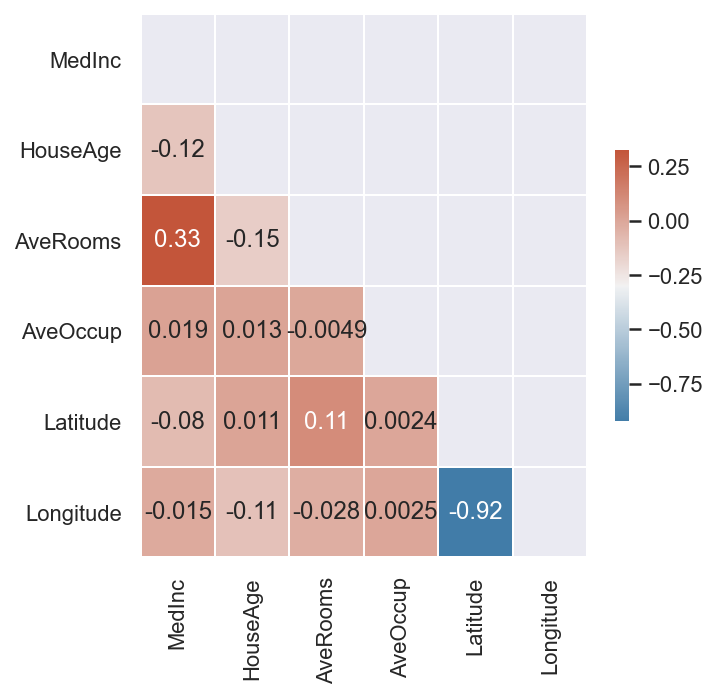

In [17]:
plot_correlation_matrix(df[numerical].corr(), size=(5, 5))

In [ ]:
plot_scatterplot_matrix(df[numerical])

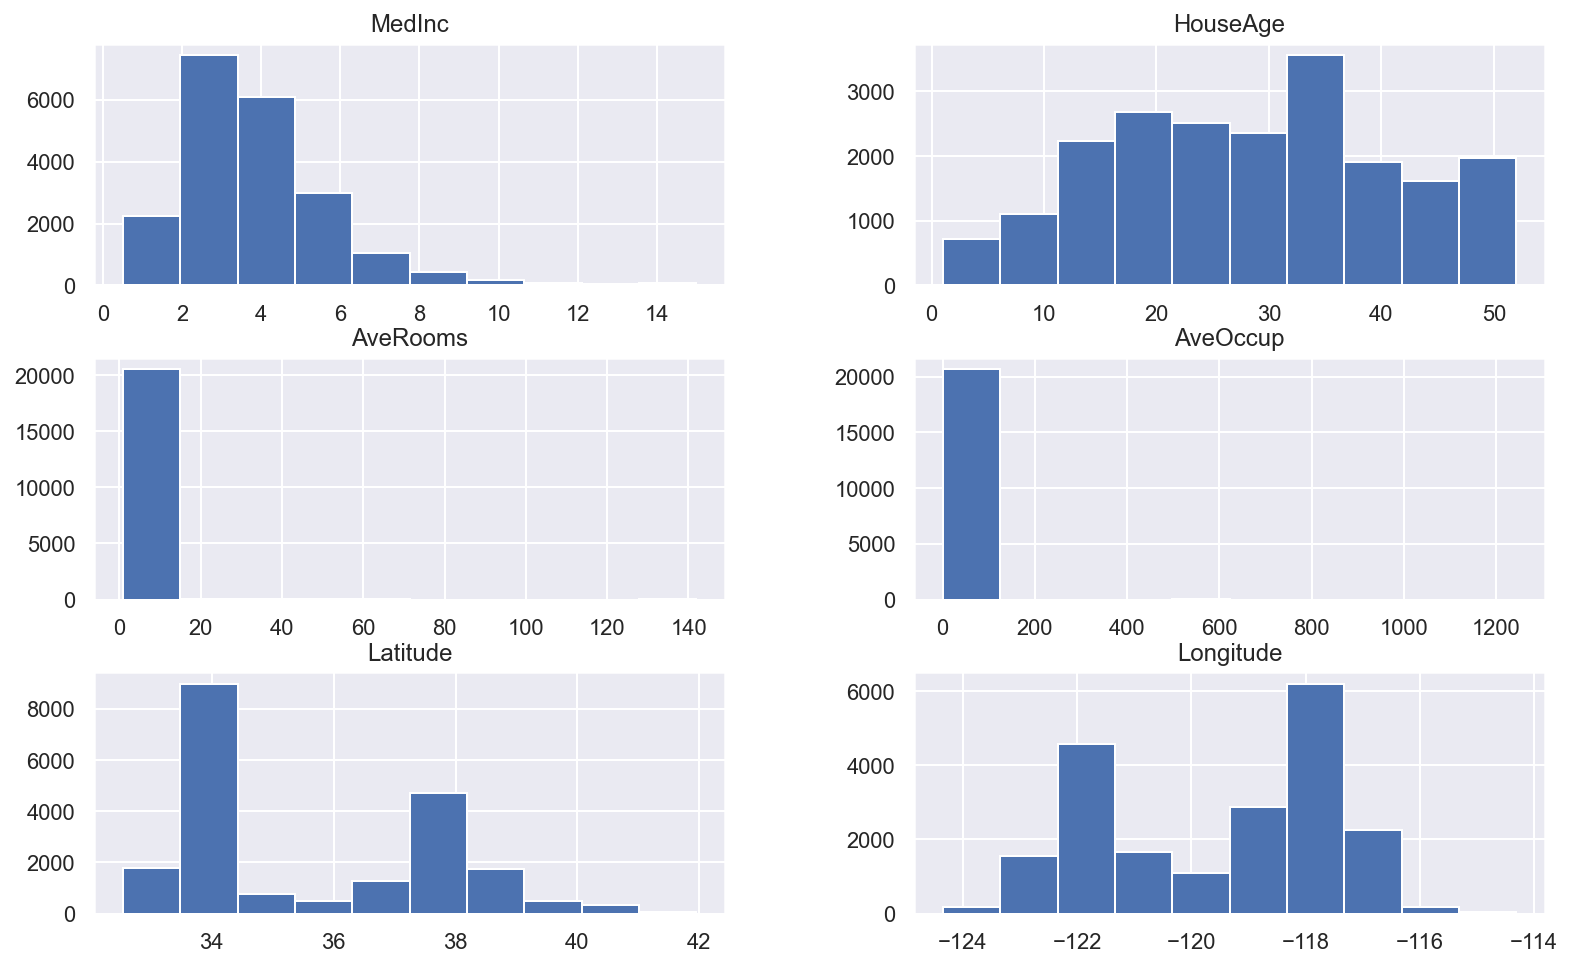

In [19]:
df[numerical].hist()
plt.show()

In [20]:
data = []
for bedrm in df.big_bedrm.unique():
    data.append(
        go.Box(y=df[df.big_bedrm == bedrm].MedInc, name=str(bedrm))
    )

iplot(data, show_link=False)